<a href="https://colab.research.google.com/github/dkaratzas/ML2024-25/blob/main/Session%2010%20-%20EM/P10_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/ML2024-25/blob/main/Session%2010%20-%20EM/P10_EM.ipynb>)

# Problems 10 - Expectation Maximisation

In this notebook we will define our own version of a Gaussian Mixture Model and use it to represent distributions and to create new samples out of them.

Then we will implement our own version of the Expectation Maximisation algorithm, and compare it with the sklearn implementation. We will take advantage of all the action to explore a couple of ways to visualise data in 3D.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

: 

# 10.1 - Gaussian Mixture Model

A Gaussian Mixture Model is basically a weighted sum of Normal (Gaussian) distributions:

$$𝑝(𝐱)=\sum_{k=1}^{N}\pi_kN(x\mid\mu_k,\Sigma_k)$$

where $\sum_{k=1}^{N}\pi_k=1$.

To manage this, we will create a class that will basically act as a collection of Normal distributions. We will provide the class means $\mu_k$ and covariances $\Sigma_k$, as well as the mixing coefficients $\pi_k$. Below is the code for this class. Go over it and try to understand what each function is supposed to do.

In [146]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, means, covs, coefs):
        """Class initilization.

        Keyword arguments:
        means -- a list of mean vectors, one for each component
        covs  -- a list of covariance matrices, one for each component
        coefs -- a list of mixing coefficients
        
        The function checks that the number of means, covariance matrices 
        and mixing coefficients agree. Otherwise it raises an exception.
        It normalises the coeficient values (so they do not have to sum to
        1 when specified), but they have to be all positive numbers.
        """        
        assert (means.ndim == 2)
        self.nComponents, self.dim = means.shape

        assert (coefs.ndim == 1)
        assert (means.shape[0] == coefs.shape[0] == self.nComponents)
        assert (covs.shape[1] == covs.shape[2] == self.dim)
        assert all(coefs > 0)
        self.means = means
        self.covs = covs
        self.coefs = coefs / coefs.sum() # Make sure these are valid probabilities
                           
    def __str__(self):
        """String representation of the class.        
        Returns an informative string about our class.
        """
        return f"GMM with {self.nComponents} components"
        
    def __call__(self, x):
        """Implements the call operator. This enables instances of our class to
        behave like functions and be called like a function.        
        It returns the probability density value at x. For this it calls the pdf() 
        function that is an alternative way to do that.
        """
        return self.pdf(x)
        
    def pdf(self, x):
        """Returns the probability density value at x.
        """
        out = 0        
        for mean, cov, coef in zip(self.means, self.covs, self.coefs):
            out += coef * multivariate_normal(mean, cov).pdf(x)
        return out
    
    def sample(self, size = None):        
        """Returns a set of feature vector, according to the size specified, sampled from the GMM.
        The final result will be of size (size, dim), where dim is the dimensionality of the feature vector
        """
        # Select random components, as many as "size" indicates
        c = np.random.choice(np.arange(self.nComponents), size=size, replace=True, p=self.coefs)
        
        # c will have the size the user specified, make it a list of indices
        clist = c.reshape(-1, 1).squeeze()
        
        # Check in case we only got a single number (not an array)
        if clist.ndim == 0: # this would happen if the user asked for only one element (dimensionality = 0), then expand it so that the rest works
            clist = np.expand_dims(clist, 0)
        
        # create the output array, as an array of size like the list of indices
        out = np.zeros( (clist.shape[0], self.dim) )
        
        # Generate samples from the corresponding clusters
        for i, cl in enumerate(clist):
            out[i] = np.random.multivariate_normal(self.means[cl], self.covs[cl])
            
        # Reshape out back to the desired size        
        out = out.reshape(c.shape + (self.dim,))
        #out = out.reshape(np.hstack( (c.shape, self.dim)).astype(int) )  # Alternative way to do this
        
        return out

Let´s first have a look at the `GMM.pdf()` fuction of this class. This class returns the probability of our GMM at some input point $x$. To understand how it works, check the documentation of the function `scipy.stats.multivariate_normal()` here:
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html

To test our function, we will manually define a GMM with two components, then use the `GMM.pdf()` function to calculate the probability density at some point $x$. We will work in a 2D space.

In [147]:
from sklearn.datasets import make_spd_matrix

rng = 12 # range to use for sampling

nComponents = 2
means = np.random.uniform(-rng+2, rng-2, size = (nComponents, 2))
covs = np.array( [make_spd_matrix(n_dim=2, random_state=r) for r in np.random.randint(100, size = nComponents)] )
coefs = np.random.uniform(1, 5, nComponents)
coefs /= nComponents # mixing coefficients, normalised

In [148]:
gmm = GMM(means, covs, coefs)
x = np.array([0, 0])
print(gmm.pdf(x))
print(gmm(x))

print(gmm(means))

0.005239806303890539
0.005239806303890539
[0.08575974 0.06318844]


Now have a look at the `GMM.sample()` function of our class. This function generates samples from our GMM distribution. To understand how it works, check the documentation of the function `random.multivariate_normal()` here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

And the function `numpy.random.choice()` here:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Here are some tests of our sampling method:

In [149]:
# Test 1 - generate a single sample
gmm.sample(1)

array([[-1.27290263, -2.34873607]])

In [150]:
# Test 2 - generate a set of 5 samples
gmm.sample(5)

array([[-3.18249887, -2.91168158],
       [ 0.0176967 , -2.86090794],
       [ 2.21344969,  0.80405257],
       [-2.60413485, -4.14736388],
       [-3.37755844, -2.49647845]])

In [151]:
# Test 3 - generate a set of 5 samples (alternative way)
gmm.sample([5])

array([[-3.10673807, -2.94666493],
       [-1.80064991, -3.34496492],
       [ 4.52298758, -1.54609121],
       [ 2.61240481,  0.36740729],
       [-0.15741895,  1.37879047]])

In [152]:
# Test 3 - generate an array of samples of the size given
gmm.sample([2, 3])

array([[[-0.59308479, -3.79690834],
        [ 1.76711013,  1.49534107],
        [ 2.54354884,  0.53144877]],

       [[ 3.31540093,  1.57463637],
        [-0.34288201,  1.42706791],
        [-2.5891148 , -2.83852653]]])

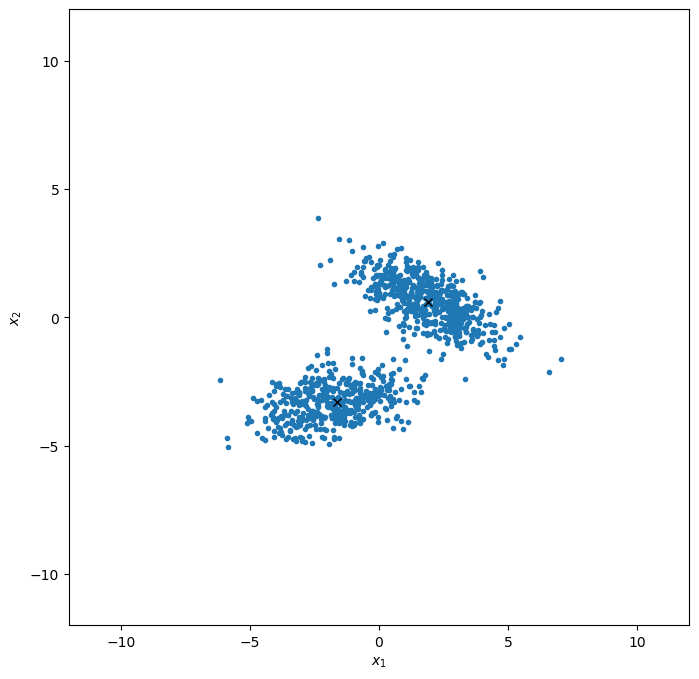

In [153]:
# Do some plotting
fig = plt.figure(figsize = (8, 8))

data = gmm.sample(1000) # generate 1000 samples
plt.scatter(data[:,0], data[:,1], marker = ".")
plt.plot(means[:,0], means[:,1], "kx")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.show()

Each one probably got a different result, as we randomly generated means, covariances and samples. We will now formalise our initialisation procedure, to create random means, covariances, and mixing coefficients in the same way, by controlling the seed we use

In [154]:
# Initialization
from sklearn.datasets import make_spd_matrix

def initialise(nComponents, rng = 10, random_seed = 6):

    np.random.seed(random_seed)

    coefs = np.ones(nComponents)/nComponents # mixing coefficients

    means = np.random.uniform(-rng+2, rng-2, size = (nComponents, 2))
    covs = np.array( [make_spd_matrix(n_dim=2, random_state=r) for r in np.random.randint(100, size = nComponents)] )
    
    return means, covs, coefs

In [155]:
nComponents = 2
means, covs, coefs = initialise(nComponents)

In [156]:
gmm = GMM(means, covs, coefs)
print(gmm)

GMM with 2 components


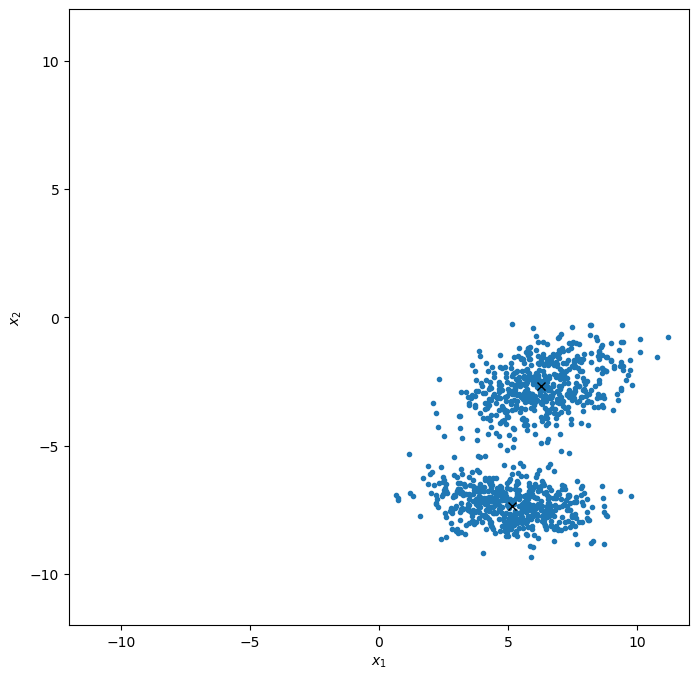

In [157]:
# Do some plotting
fig = plt.figure(figsize = (8, 8))

data = gmm.sample(1000)
plt.scatter(data[:,0], data[:,1], marker = ".")
plt.plot(means[:,0], means[:,1], "kx")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.show()

In [158]:
gmm( [0, 0] ) # The probability density function at [0, 0]

1.5471807357298683e-09

## 10.2 - Expectation Maximisation

Here we will use our our implementation of Expectation Maximisation.

We will initialise with some random clusters, and apply EM on the data they have provided us. First we will load and explore the data we have been given.

In [159]:
import pickle
import gzip

In [160]:
with gzip.open('data.pklz', 'rb') as f:
    (X, y) = pickle.load(f)

Let's first explore a bit and visualise the data we just loaded

In [161]:
print("Feature dimension: ", X.ndim)
for i, column in enumerate(X.T):
    print("Feature {index} in [{minimum:.2f}, {maximum:.2f}]".format(index = i, minimum = column.min(), maximum = column.max()))
    
for label in np.unique(y):
    print("Label {} count: {} ({:.2f}%)".format(label, np.sum(y == label), 100*np.sum(y == label)/len(y) ))

Feature dimension:  2
Feature 0 in [-8.36, 11.69]
Feature 1 in [-10.37, 6.14]
Label 0 count: 63 (31.50%)
Label 1 count: 137 (68.50%)


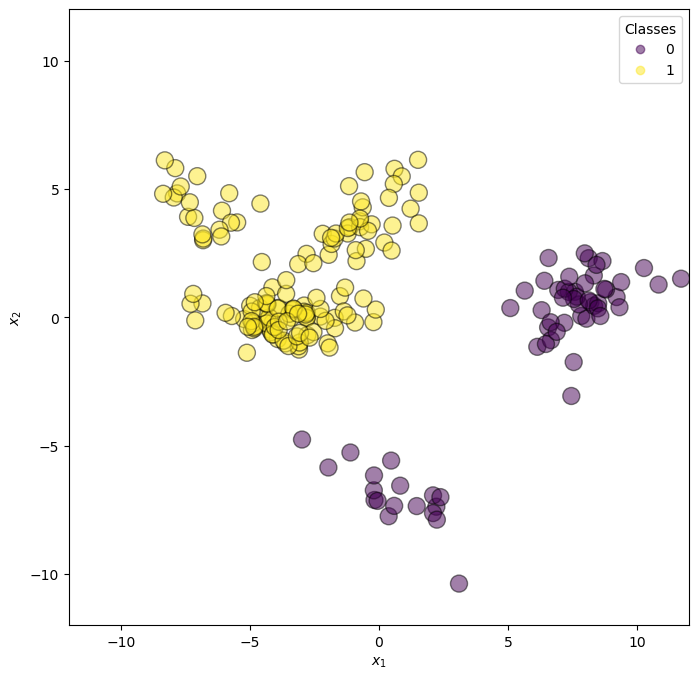

In [162]:
fig = plt.figure(figsize = (8, 8))
scatter = plt.scatter(X[:,0], X[:,1], c = y, marker = "o", alpha = 0.5, cmap="viridis", label = y, s=150, edgecolors="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
plt.show()

Now for the implementation of our Expectation Maximisation function. We will start with a number of random components. Then in every iteration (epoch) we will calculate:

**EXPECTATION STEP:**

(1) the "responsibilities" of each component for each point of our dataset:

$$\gamma(z_{nk})=\frac{\pi_k N(x^{(n)}\mid\mu_k, \Sigma_k)}{\sum_{j=1}^K\pi_j N(x^{(n)}\mid\mu_j, \Sigma_j)} $$

**MAXIMISATION STEP:**

(2) the new means:

$$\mu_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x^{(n)}$$

(3) the new covariance matrices:

$$\Sigma_k^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(x^{(n)}-\mu_k^{new})(x^{(n)}-\mu_k^{new})^T$$

where

$$N_k=\sum_{n+1}^N\gamma(z_{nk})$$

In [163]:
from scipy.stats import multivariate_normal

def em(X, means, covs, coefs, nIter = 100, resetSingulars = False, epsilon = 1e-6):
    '''Implements the Expectation - Maximisation algorithm for estimating probability density using a Gaussian Mixture Model
    means          - The initial means to use
    covs           - The initial covariance matrices to use
    coefs          - The initial mixture coefficients to use
    nIter          - Number of epochs to do
    resetSingulars - If True, it checks for singular compoments and resets them to a new position. If False, 
                     it avoids singular components by adding a small epsilon value on the diagonal of all covariance matrices
    epsilon        - The epsilon to use if resetSingulars is set to False
    '''
    for epochs in range(nIter):
        # (E-Step)
        # Calculate the responsibilities
        gamma = np.array([z * multivariate_normal(m, c).pdf(X) for m, c, z in zip(means, covs, coefs)])
        gamma /= gamma.sum(axis=0)

        # (M-Step)
        # Calculate the Ns (the sum of this vector should equal the total number of points)
        N = gamma.sum(axis = 1)

        # Calculate means
        means = np.array([(gamma[i,:] * X.T).sum(axis=1)/n for i, n in enumerate(N)])

        # Calculate new coefficients
        coefs = N/sum(N)

        # Calculate covariances
        covs = np.array([(gamma[i,:] * (X - m).T) @ (X - m)/n for i, (m, n), in enumerate(zip(means, N))])    

        # Deal with any singular components, we offer two ways
        if resetSingulars:
            # Check if any component has become singular and reset it to a random place
            # ensure that I will never get a singular matrix
            nDims = means.shape[1]
            if any(np.linalg.matrix_rank(covs) < nDims):
                print("Singular covariance found, resetting component")
                idx = (np.linalg.matrix_rank(covs) < nDims)
                nSingulars = idx.sum()
                means[idx] = np.random.uniform(-rng+2, rng-2, size = (nSingulars, 2))
                covs[idx] = np.array( [make_spd_matrix(n_dim=nDims, random_state=r) for r in np.random.randint(100, size = nSingulars)] )
                coefs[idx] = (1/coefs.shape[0])
                coefs = coefs/sum(coefs)
        else:
            # Or alternatively, do not reset any component, just avoid singularities
            covs += epsilon * np.identity(covs.shape[1]) # Avoid singular matrices
            
    return means, covs, coefs

Set some initial values for the components, and run the EM algorithm on our dataset

In [164]:
nComponents = 2
means, covs, coefs = initialise(nComponents)

In [165]:
pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

<font color = "blue">Create a GMM using the predicted means, covariance matrices, and mixing coeficients and generate 500 samples. Then plot the generated points - do they make sense? </font>

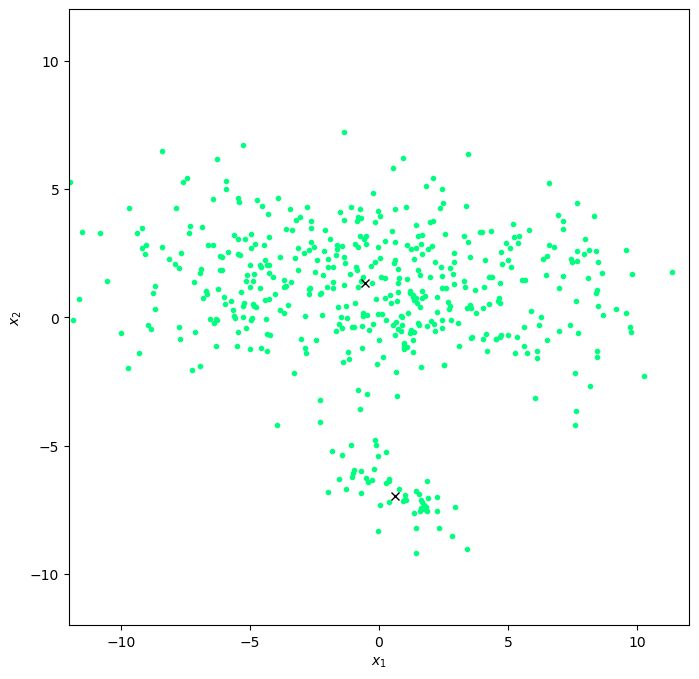

In [166]:
# create a GMM using predicted means, covariance matrices and coeficients
gmm = GMM(pred_means, pred_covs, pred_coefs)

#plot the result
fig = plt.figure(figsize = (8, 8))

data = gmm.sample(500) # generate 500 samples
plt.scatter(data[:,0], data[:,1], color='springgreen', marker = ".")
plt.plot(pred_means[:,0], pred_means[:,1], "kx")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-rng, rng)
plt.ylim(-rng, rng)
plt.show()

---

The result of the plot makes sense. On the one hand, the crosses, representing the means of the Gaussian components obtained from EM, are placed in the center of the clusters, suggesting that the clustering reflects the underlying structure in the data. 

On the other hand, the data points are scattered around the cluster centers in a consistent way, the density of points decreases as we move further away from the cluster centers, and increases as we approach the clusters. Which aligns with the shape of the Gaussians distributions. Which indicates us that the EM has modelled the data well using a GMM. 

---

Here's a function to plot contours

In [167]:
def plot_contours(f, data, means = None, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots contours, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    cm = plt.cm.Set1
    plt.scatter(data[:,0], data[:,1], color = "grey" if (labels is None) else cm(labels), marker = ".")

    cm = plt.cm.coolwarm
    levels = np.linspace(0.0001, min(0.04, np.max(ZZ)), 7)
    plt.contour(XX, YY, ZZ, cmap = cm, levels = levels)
    
    if means is not None:
        plt.plot(means[:, 0], means[:, 1], "kx")

    plt.show()

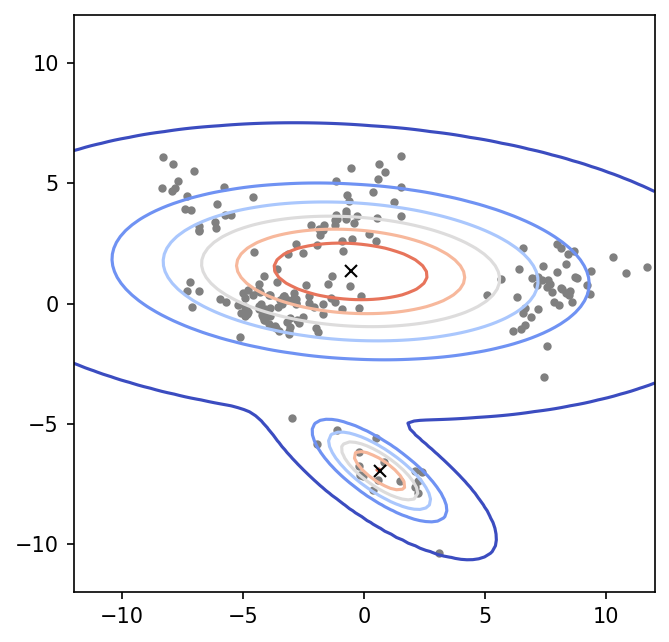

In [168]:
plot_contours(gmm, X, pred_means)

Just to do a quick check, we calculate the volume under surface in the region plotted (should be close to 1, as most of the action happens here, but the GMM extends to infinity, so there is a part of the volume outside the shown region)

In [169]:
import numpy as np
import scipy.spatial

def trapezoidal_area(xyz):
    """Calculate volume under a surface defined by irregularly spaced points
    using delaunay triangulation. "x,y,z" is a <numpoints x 3> shaped ndarray."""
    d = scipy.spatial.Delaunay(xyz[:,:2])
    tri = xyz[d.simplices]

    a = tri[:,0,:2] - tri[:,1,:2]
    b = tri[:,0,:2] - tri[:,2,:2]
    vol = np.cross(a, b) @ tri[:,:,2]
    return vol.sum() / 6.0

In [170]:
XX = np.linspace(-12, 12, 100)
YY = np.linspace(-12, 12, 100)
XX, YY = np.meshgrid(XX, YY)
ZZ = gmm( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )

xyz = np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1), ZZ.reshape(-1, 1)))

trapezoidal_area(xyz)

0.9788906932120947

Here are a couple of more plots, to help with your exploration.

In [171]:
def plot_surface(f, data, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots a surface plot, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)
    ax = fig.add_subplot(projection = "3d")

    zl = 0.04 # The z limit we will use

    # Plot the 3D surface    
    ax.plot_surface(XX, YY, ZZ, edgecolor='royalblue', lw=0.2, rstride=2, cstride=2, alpha=0.3,  cmap = 'coolwarm')
    
    # Set axis limits, labels, ticks
    ax.set(xlim=xlim, ylim=ylim, zlim=(0, zl), xlabel='$x_1$', ylabel='$x_2$', zlabel='$p(x)$')
    ax.set_xticks(np.arange(xlim[0], xlim[1]+1, 5) )
    ax.set_yticks(np.arange(xlim[0], xlim[1]+1, 5) )

    # Rotate the graph    
    ax.view_init(elev = 25, azim = -70)

    plt.show()

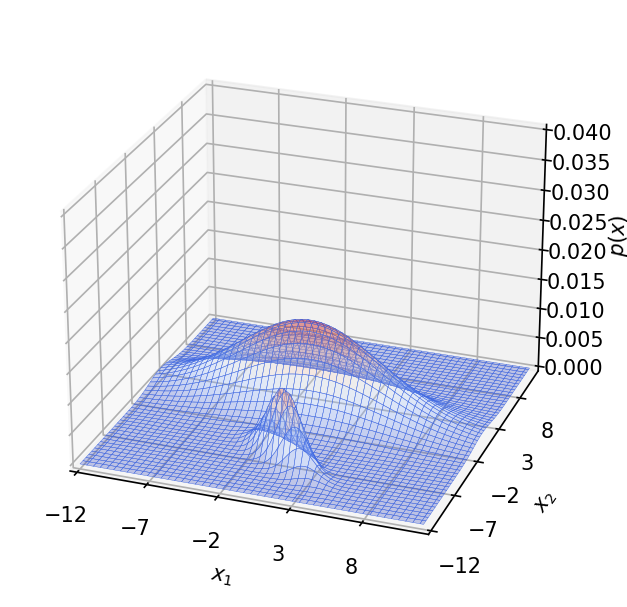

In [172]:
plot_surface(gmm, X)

In [173]:
def plot_combined(f, data, labels = None, xlim = (-12, 12), ylim = (-12, 12), resolution = 100):
    '''Plots a combined contour and surface plot, given a function f
    f          - reference to a function that accepts 2-dimensional points as input. E.g. f([x, y])
    data       - a list of data points. Rows are points, columns are features. 2-dimensional points are expected (extra dimensions are ignored)
    labels     - if given, they will be used to colour the points
    xlim       - the x-limits of the plot
    ylim       - the y-limits of the plot
    resolution - the sampling resolution to use to calculate the contours
    '''
    XX = np.linspace(xlim[0], xlim[1], resolution)
    YY = np.linspace(ylim[0], ylim[1], resolution)

    XX, YY = np.meshgrid(XX, YY)

    ZZ = f( np.hstack( (XX.reshape(-1, 1), YY.reshape(-1, 1)) ) )
    ZZ = ZZ.reshape(XX.shape)
    
    fig = plt.figure(figsize = (5, 5), dpi = 150)
    ax = fig.add_subplot(projection = "3d")

    zl = 0.04 # The z limit we will use

    # Plot the 3D surface
    ax.plot_surface(XX, YY, ZZ, edgecolor='royalblue', lw=0.2, rstride=1, cstride=1, alpha=0.3,  cmap = 'coolwarm')

    # Plot a projection of the contour
    ax.contourf(XX, YY, ZZ, zdir='z', offset=-2*zl, cmap='coolwarm')

    # Plot the data
    ax.scatter(X[:,0], X[:,1], -2*zl, c = "black", marker = "+", s= 10, linewidth = 0.5)

    # Rotate the graph
    ax.view_init(elev = 20, azim = -60)

    # Set axis limits, labels, ticks
    ax.set(xlim=(-rng, rng), ylim=(-rng, rng), zlim=(-2*zl, zl), xlabel='$x_1$', ylabel='$x_2$', zlabel='$p(x)$')
    ax.set_xticks(np.arange(-rng, rng+1, 5) )
    ax.set_yticks(np.arange(-rng, rng+1, 5) )

    plt.show()

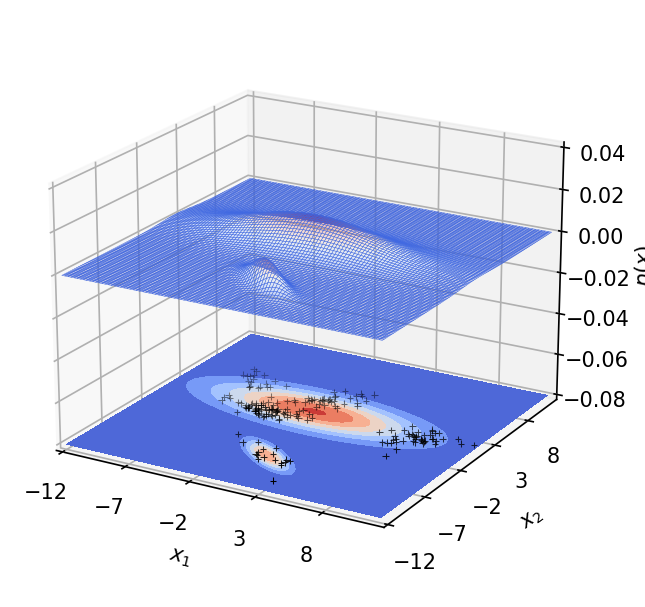

In [174]:
plot_combined(gmm, X)

<font color ="blue">Now, try fitting an GMM model using EM with a different number of components, or try to randomise the initialisation differently, try to use both ways provided to deal with singular components, etc. Report your findings.</font>

Change the number of components:

Contours and Combined plot with nComponents=1


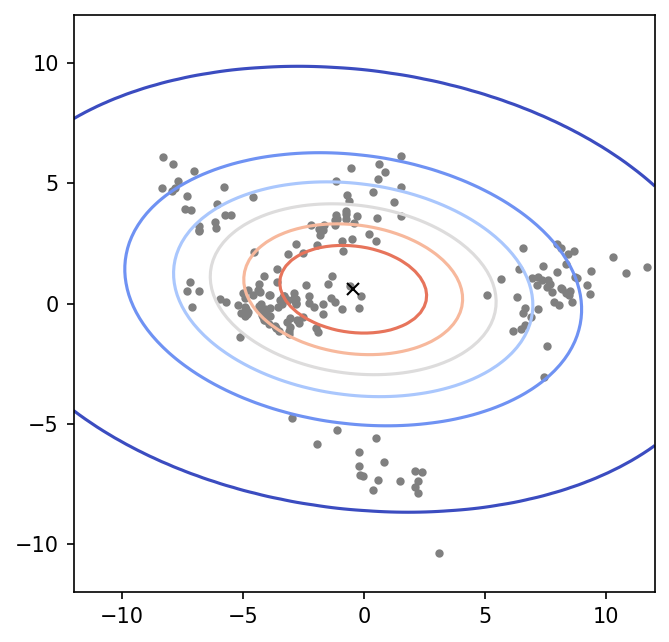

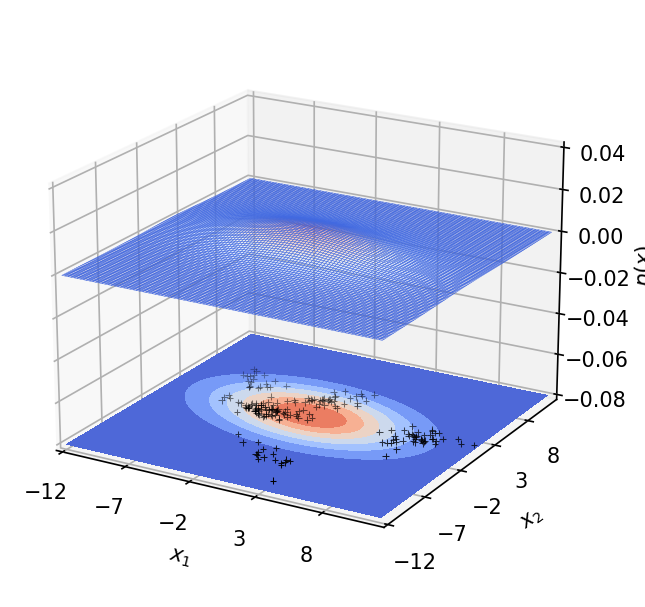

Contours and Combined plot with nComponents=4


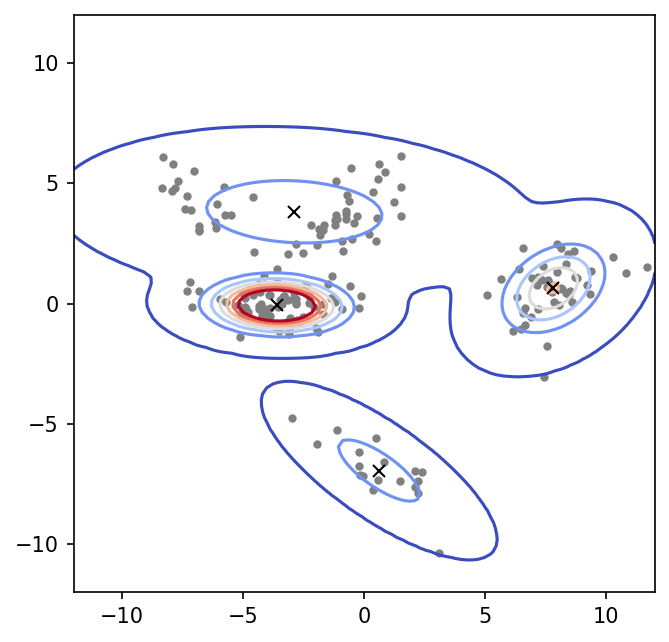

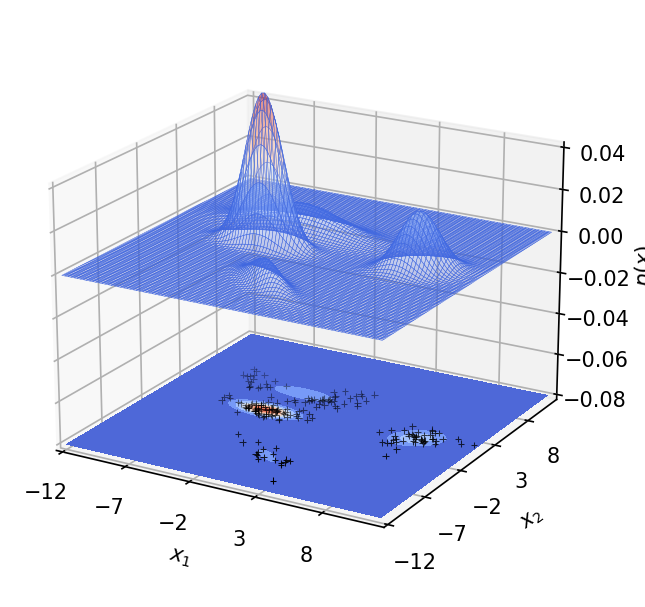

Contours and Combined plot with nComponents=6


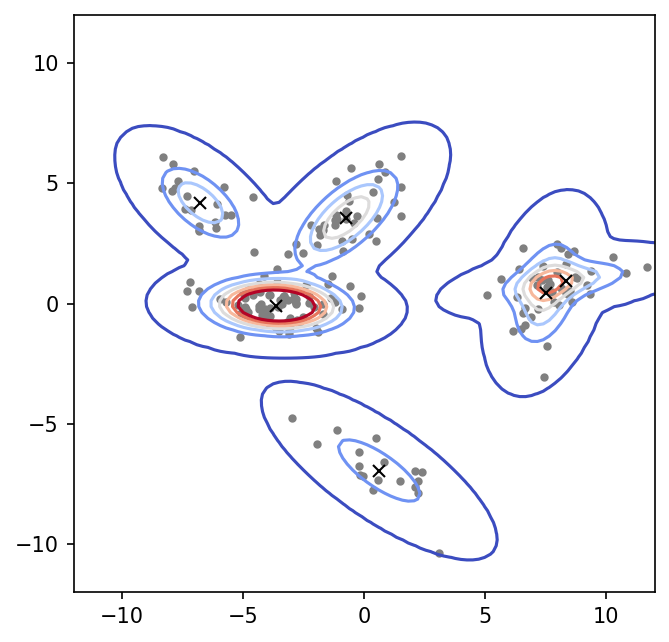

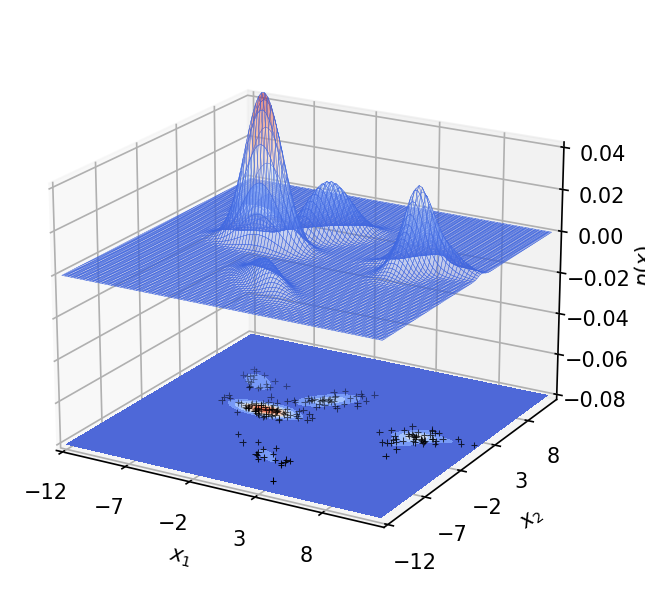

In [175]:
# Different number of components
rangeComponents = [1, 4, 6]

for nComponents in rangeComponents:

    means, covs, coefs = initialise(nComponents)

    pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

    # create a GMM using predicted means, covariance matrices and coeficients
    gmm = GMM(pred_means, pred_covs, pred_coefs)

    #plot contours
    print(f"Contours and Combined plot with nComponents={nComponents}")
    plot_contours(gmm, X, pred_means)
    plot_combined(gmm, X, pred_means)

*As we increase the number of components the model fits better the data. However, if we increased it too much, the model would overfit to the data, and we could also end up with singularities.* 

Initialize values with different ranges:

Surface with rng=5


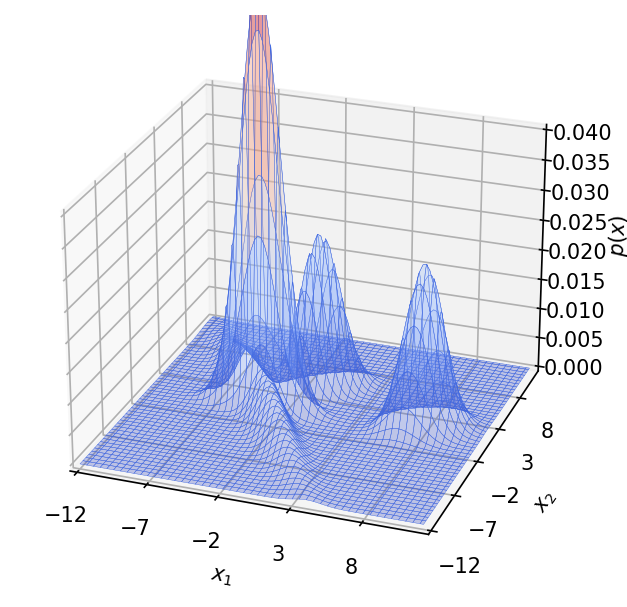

Surface with rng=20


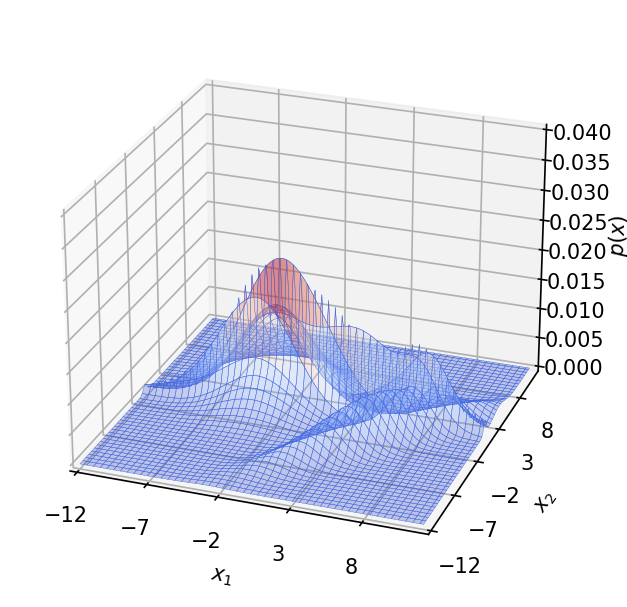

In [176]:
# Different range

for rng in [5,20]:

    means, covs, coefs = initialise(nComponents=4, rng=rng)

    pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

    # create a GMM using predicted means, covariance matrices and coeficients
    gmm = GMM(pred_means, pred_covs, pred_coefs)

    #plot contours
    print(f"Surface with rng={rng}")
    plot_surface(gmm, X, pred_means)

*In the first plot (`rng=5`) the small range likely restricted the initialization of means to a small region, causing the GMM to fail to effectively model the entire data distribution, leading to the sharp peaks.* 

*In the second plot (`rng=20`) the larger range allows the initialization of the means to be more widely spread across the feature space. This reduces the likelihood of components overlapping or collapsing.*

Two different ways of dealing with singular components: the first one with the default value for the parameter `resetSingulars=False`, which adds an epsilon value on the diagonal of the covariance matrices when it finds a singularity. And the second one, by setting `resetSingulars=True` , which resets components that become singular to a new place. 

Contours and Combined plot using resetSingular=False: 


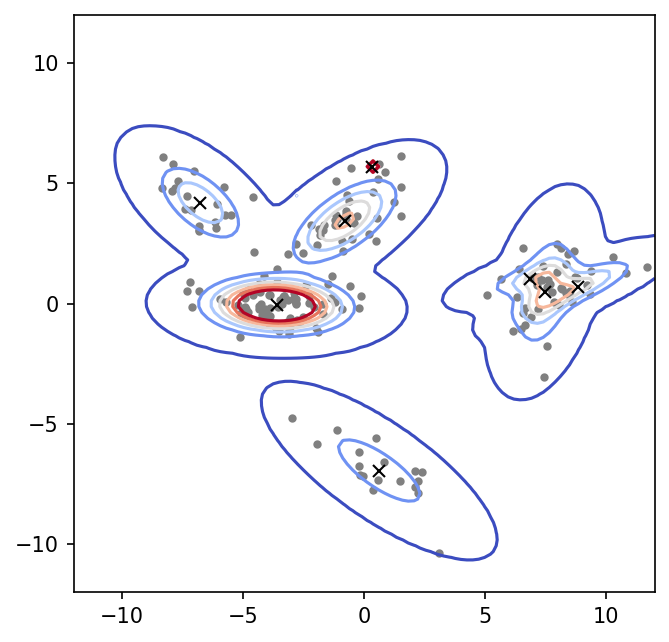

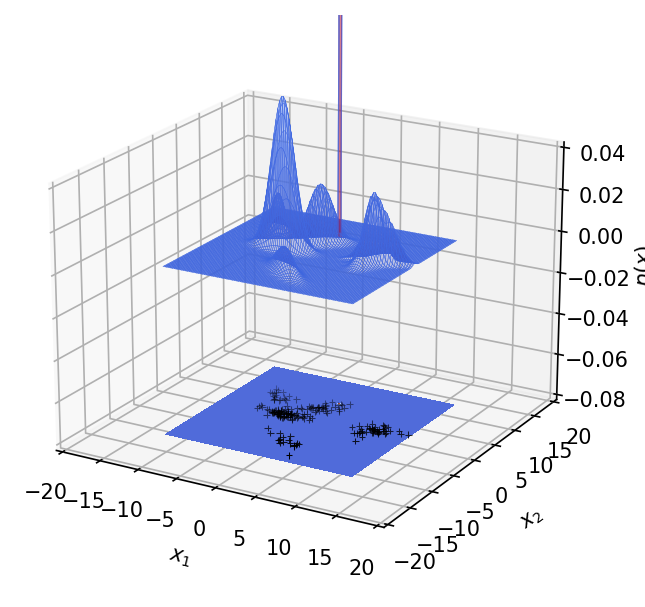

Contours and Combined plot using resetSingular=True: 
Singular covariance found, resetting component
Singular covariance found, resetting component
Singular covariance found, resetting component
Singular covariance found, resetting component
Singular covariance found, resetting component


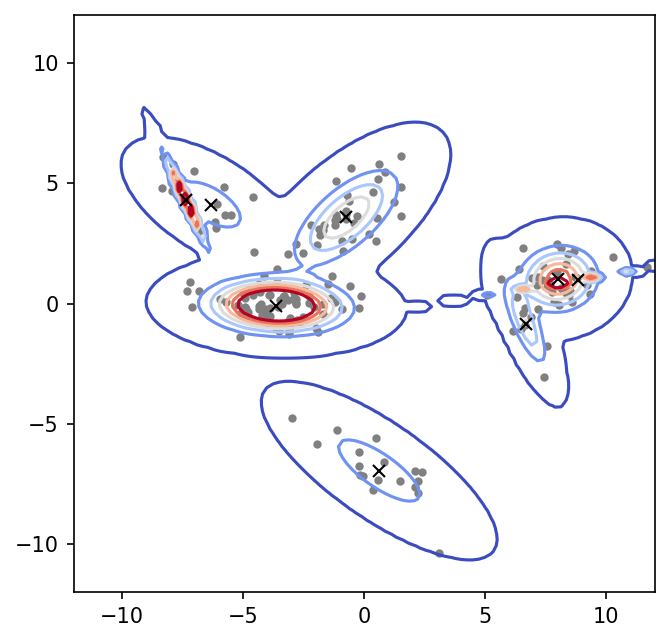

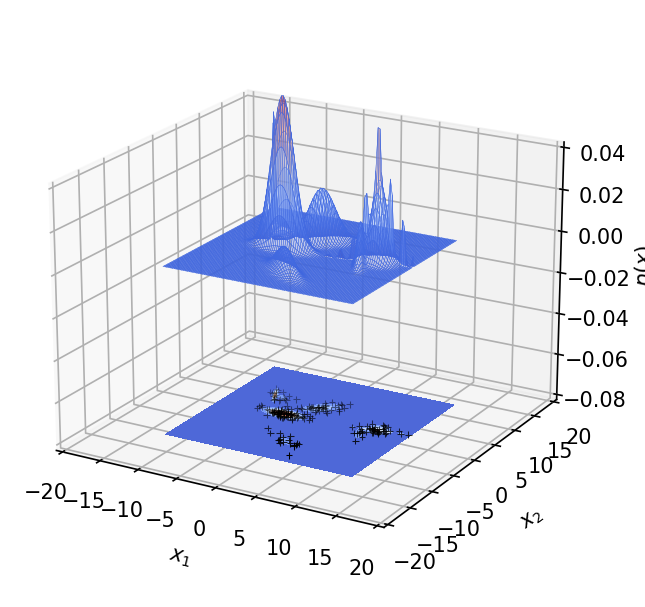

In [177]:
nComponents= 8

#resetSingular=False

means, covs, coefs = initialise(nComponents)

pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

# create a GMM using predicted means, covariance matrices and coeficients
gmm = GMM(pred_means, pred_covs, pred_coefs)

#plot contours
print(f"Contours and Combined plot using resetSingular=False: ")
plot_contours(gmm, X, pred_means)
plot_combined(gmm, X, pred_means)

#resetSingular=True 

means, covs, coefs = initialise(nComponents)

print(f"Contours and Combined plot using resetSingular=True: ")

pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs, resetSingulars=True)

# create a GMM using predicted means, covariance matrices and coeficients
gmm = GMM(pred_means, pred_covs, pred_coefs)

#plot contours
plot_contours(gmm, X, pred_means)
plot_combined(gmm, X, pred_means)

---

*In the first plot (`resetSingulars=False`) we can see a narrow, high peak. This spike represents a component that has collapsed to a nearly singular state. Even though it does not truly reach it because of the epsilon value that it is added to the diagonal of the covariance matrices.*

*In the second plot (`resetSingulars=True`) there are no singularities or high peaks. This is because each time a singularity is found, the algorithm resets it to a new location. Avoiding singularities in this way. However, if we used a very high number of components we would increases the likelihood of components collapsing because there may not be enough data to support each component.*

---

## 10.3 - Using sklearn

Here we explore the SciKit Learn solution to do the same as above. In sklearn, the EM algorithm is integrated in the GMM class' `fit()` function.

To compare it to our own implementation, we will initialise it ourselves manually, to the same values as we did with ours (we will always be recalculating ours with the same initial conditions).

In [178]:
nComponents = 4
means, covs, coefs = initialise(nComponents)

# The sklearn implementation requires precisions instead of covariance matrices (which are just the inverse of the covariances)
precs = np.linalg.inv(covs)

In [179]:
from sklearn.mixture import GaussianMixture

gmm_sklearn = GaussianMixture(n_components=nComponents, weights_init = coefs, means_init = means, precisions_init = precs, max_iter = 100).fit(data)
print(gmm_sklearn.means_)
print(gmm_sklearn.covariances_)

[[ 6.3865817   0.8257772 ]
 [ 0.49470546 -6.70445463]
 [-2.33521737  1.79161225]
 [ 1.2392269  -0.22350359]]
[[[ 6.49251718 -0.69840613]
  [-0.69840613  3.9270051 ]]

 [[ 2.12089703 -1.192494  ]
  [-1.192494    1.228176  ]]

 [[19.99986344  0.13625965]
  [ 0.13625965  3.46578198]]

 [[ 3.04183112  0.52555922]
  [ 0.52555922  1.23107388]]]


Let's visualise the results of sklearn.

*NOTE: There is no equivalent to our `pdf()` function... Instead, the function that we can use here is called `GaussianMixture.score_samples()` and returns the log likelihood, while we want to plot the likelihood. So, to compare equal things we we need to exponantiate this.*

In [180]:
def f(x):
    return np.exp(gmm_sklearn.score_samples(x))

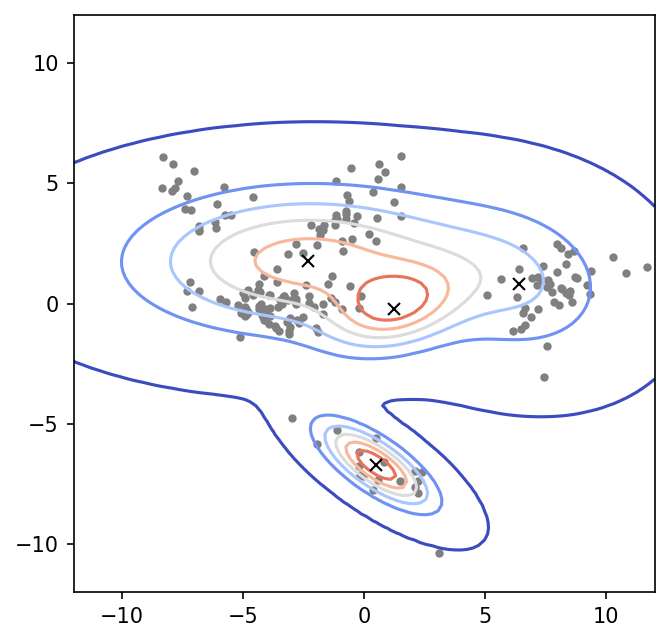

In [181]:
    plot_contours(f, X, gmm_sklearn.means_)

<font color = "blue">Compare these results to our implementation, to make sure our implementation works well (make sure you are using the same initial values).</font>

Means: 
 [[ 7.81243941  0.63752147]
 [ 0.61795644 -6.93573888]
 [-2.88458141  3.8190999 ]
 [-3.61414917 -0.07450846]]
Covariances: 
 [[[ 1.61271007  0.48327031]
  [ 0.48327031  1.20427648]]

 [[ 2.47693441 -1.45434105]
  [-1.45434105  1.43309537]]

 [[10.0480658  -0.43404359]
  [-0.43404359  1.28467441]]

 [[ 2.1683513  -0.05386398]
  [-0.05386398  0.3575379 ]]]


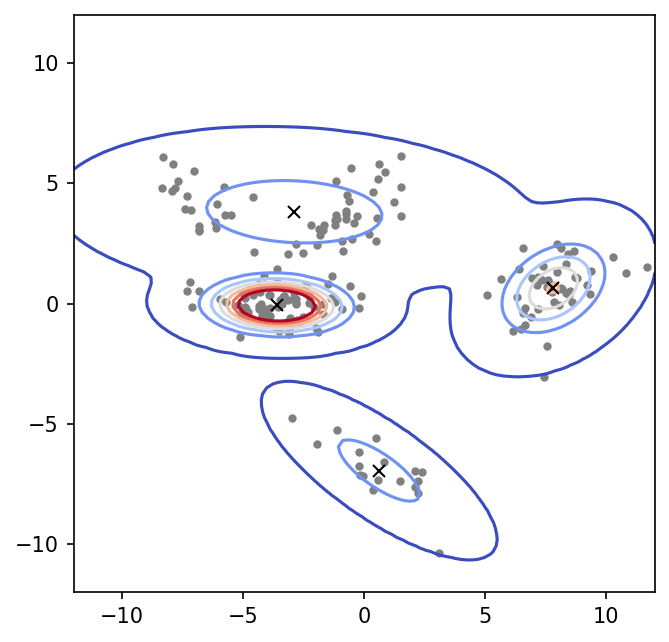

In [182]:
# set initial number of components
nComponents = 4

# run EM algorithm on initial values computed above
pred_means, pred_covs, pred_coefs = em(X, means, covs, coefs)

# create a GMM using predicted means, covariance matrices and coeficients
gmm = GMM(pred_means, pred_covs, pred_coefs)

# show means and covariances
print("Means: \n", gmm.means)
print("Covariances: \n", gmm.covs)

# plot the result
plot_contours(gmm, X, pred_means)

# 10.4 - Make Predictions

The original dataset also had class information. Therefore we can calculate the likelihood (class conditional probability of x) for each class, as well as the prior of each class, and then use it to predict posterior probabilities for new data.

<font color = "blue">Calculate the prior probabilities of the two classes</font>

In [190]:
# Prior probabilities
P_class0 = len(X_class0) / len(X)
P_class1 = len(X_class1) / len(X)

print("Class 0 prior:", P_class0)
print("Class 1 prior:", P_class1)

Class 0 prior: 0.315
Class 1 prior: 0.685


<font color = "blue">Calculate the class likelihoods (class conditioned probability density functions) for the two classes, using EM</font>

In [191]:
X_class0 = X[y == 0]  
X_class1 = X[y == 1]

nComponents = 2
means, covs, coefs = initialise(nComponents)

# Fit the EM model for class 0
pred_means0, pred_covs0, pred_coefs0 = em(X_class0, means, covs, coefs)
gmm_0 = GMM(pred_means0, pred_covs0, pred_coefs0)

# Fit the EM model for class 1
pred_means1, pred_covs1, pred_coefs1 = em(X_class1, means, covs, coefs)
gmm_1 = GMM(pred_means1, pred_covs1, pred_coefs1)

# Compute the likelihoods for each class
likelihood_class0 = gmm_0.pdf(X)
likelihood_class1 = gmm_1.pdf(X)

# Print the likelihoods
print("Likelihoods for Class 0:\n", likelihood_class0)
print("Likelihoods for Class 1:\n", likelihood_class1)

Likelihoods for Class 0:
 [2.75351050e-25 4.77941367e-22 6.45662590e-10 1.97260064e-15
 7.83959610e-04 4.26350057e-09 6.33943069e-31 1.18707807e-08
 5.65627348e-10 1.15499791e-19 2.76494317e-03 4.10571570e-09
 3.93886579e-19 1.82948572e-02 1.00599074e-14 1.42684927e-09
 7.36683450e-02 3.57808591e-18 2.37022152e-02 5.48376224e-02
 2.62692786e-02 4.31713559e-02 2.49888903e-09 2.80942716e-15
 7.85023142e-02 1.69633136e-02 3.88383270e-19 7.24983096e-02
 1.65189690e-02 2.77311504e-13 6.53030015e-02 8.21885827e-02
 2.22035855e-11 7.02690488e-03 3.92312489e-15 7.99936427e-19
 5.99696225e-12 7.56875834e-02 1.90197000e-04 7.04283921e-14
 1.28808120e-02 5.76220078e-02 4.92829800e-24 8.79420272e-26
 2.50926990e-12 3.27692477e-02 4.23005066e-10 2.47396775e-09
 6.17188808e-13 6.05188840e-22 2.97198418e-02 2.32710130e-02
 1.31474450e-21 7.50066797e-09 4.37226017e-14 3.43239294e-11
 4.63611313e-02 2.36550152e-08 1.20142521e-14 1.17990578e-02
 8.61420043e-02 6.06055519e-08 7.55666392e-03 8.80239553e-1

<font color = "blue">Now apply Bayes, and calculate the posterior probabilities for each class for points [-3, 2], [7, 0], [1,-6], [5, -5]. To which class would you classify each point?</font>

In [208]:
# Points to classify
points = np.array([[-3, 2], [7, 0], [1, -6], [5, -5]])

# Compute likelihoods for points
likelihood_class0_points = gmm_0.pdf(points)
likelihood_class1_points = gmm_1.pdf(points)

# Compute posterior probabilities of given points for each class
P_x = (likelihood_class0_points * P_class0 + likelihood_class1_points * P_class1)
posterior_class0 = (likelihood_class0_points * P_class0) / P_x
posterior_class1 = (likelihood_class1_points * P_class1) / P_x

In [210]:
# Classify points and show results
for i, point in enumerate(points):
    print(f"\nPoint {point}:")

    print(f"Posterior probability class 0: {posterior_class0[i]:.4f}")
    print(f"Posterior probability class 1: {posterior_class1[i]:.4f}")

    if posterior_class0[i] > posterior_class1[i]:
        print("Classified as class 0") 
    else:
        print("Classified as class 1")


Point [-3  2]:
Posterior probability class 0: 0.0000
Posterior probability class 1: 1.0000
Classified as class 1

Point [7 0]:
Posterior probability class 0: 1.0000
Posterior probability class 1: 0.0000
Classified as class 0

Point [ 1 -6]:
Posterior probability class 0: 0.9991
Posterior probability class 1: 0.0009
Classified as class 0

Point [ 5 -5]:
Posterior probability class 0: 0.2800
Posterior probability class 1: 0.7200
Classified as class 1


<font color = "blue">Make a function to classify a point using the Bayes rule.</font>

In [227]:
def classify_point(point, gmm_0, gmm_1, P_class0, P_class1):

    # Compute likelihoods
    likelihood_class0 = gmm_0.pdf(point)
    likelihood_class1 = gmm_1.pdf(point)
    
    # Compute marginal likelihood P(x)
    P_x = likelihood_class0 * P_class0 + likelihood_class1 * P_class1
    
    # Compute posterior probabilities
    posterior_class0 = (likelihood_class0 * P_class0) / P_x
    posterior_class1 = (likelihood_class1 * P_class1) / P_x
    
    # Classify the point
    predicted_class = 0 if posterior_class0 > posterior_class1 else 1
    
    posteriors = f'class_0: {posterior_class0:.4f}, class_1: {posterior_class1:.4f}'
    
    return predicted_class, posteriors

*Example: Try to classify a point, in this case [-5,0]:*

In [233]:
point = [-5,0]
c, p = classify_point(point, gmm_0, gmm_1, P_class0, P_class1)

print(f"Point {point} belongs to class {c}")
print("\nPosterior probabilities for each class: \n", p)

Point [-5, 0] belongs to class 1

Posterior probabilities for each class: 
 class_0: 0.0000000170, class_1: 0.9999999830
